In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from jax import vmap, jit
import jax.numpy as jnp
from pathlib import Path
import numpy as np
from einops import rearrange
import jax
import matplotlib.pyplot as plt
import seaborn as sns
from hflow.misc.plot import scatter_movie, imshow_movie
from jax import grad, vmap, value_and_grad
from hflow.run import build
from hflow.config import Config, Sample
from functools import partial
from hflow.train.adam import adam_opt
from hflow.train.sample import get_arg_fn
from hflow.train.loss import Action_Match
from hflow.run import build
from hflow.config import Config, Sample, Loss, Data
from hflow.train.loss import Action_Match

In [22]:

cfg = Config(problem='osc', loss=Loss(sigma=0.0), data=Data(t_end=14))
key, data, loss_fn, _, s_fn, params_init = build(cfg)

In [23]:

arg_fn_gauss = get_arg_fn(Sample(scheme_t='gauss', bs_t=128), data)
last_params, opt_params, loss_history, param_history = adam_opt(params_init, loss_fn, arg_fn_gauss, steps=2500, learning_rate=1e-3, verbose=True, scheduler=True, key=key, return_params=True)



  0%|          | 0/2500 [00:00<?, ?it/s]

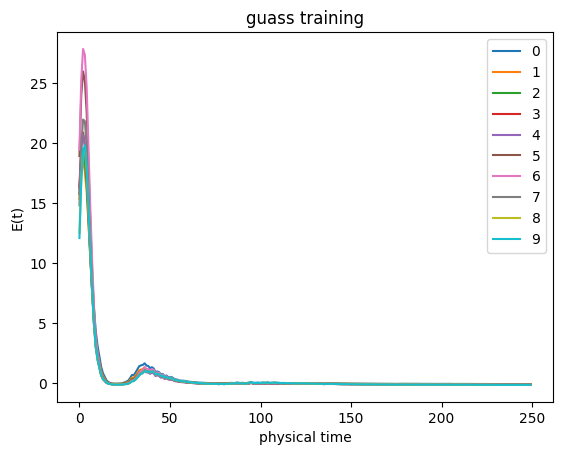

In [24]:


arg_fn_equi = get_arg_fn(Sample(scheme_t='equi', bs_t=250), data)
loss_fn2 = Action_Match(s_fn, noise=0.0, sigma=0.0, return_interior=True)
loss_data = arg_fn_equi(key)
interiors_gauss = []
for i, p in enumerate(param_history[40:50]):
    loss, interior = loss_fn2(p, *loss_data, key)
    interiors_gauss.append(interior)
    plt.plot(interior, label=i)

interiors_gauss = np.asarray(interiors_gauss)
plt.ylabel('E(t)')
plt.xlabel('physical time')
plt.legend()
plt.title('guass training')
plt.show()

In [25]:

arg_fn_rand = get_arg_fn(Sample(scheme_t='rand', bs_t=128), data)
last_params, opt_params, loss_history, param_history = adam_opt(params_init, loss_fn, arg_fn_rand, steps=2500, learning_rate=1e-3, verbose=True, scheduler=True, key=key, return_params=True)



  0%|          | 0/2500 [00:00<?, ?it/s]

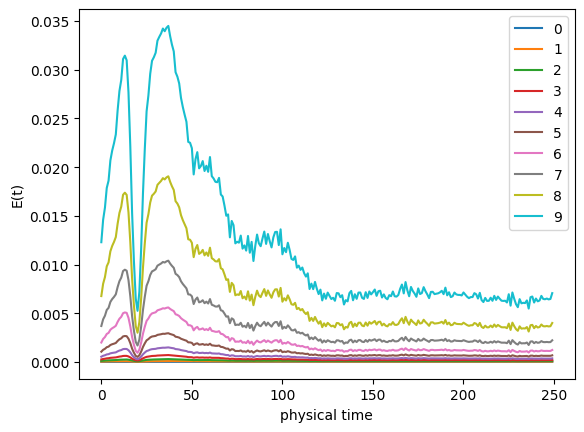

In [33]:


arg_fn_equi = get_arg_fn(Sample(scheme_t='equi', bs_t=250), data)
loss_fn2 = Action_Match(s_fn, noise=0.0, sigma=0.0, return_interior=True)
loss_data = arg_fn_equi(key)
interiors_rand = []
for i, p in enumerate(param_history[:10]):
    loss, interior = loss_fn2(p, *loss_data, key)
    interiors_rand.append(interior)
    plt.plot(interior, label=i)

interiors_rand = np.asarray(interiors_rand)
plt.ylabel('E(t)')
plt.xlabel('physical time')
plt.legend()
plt.show()

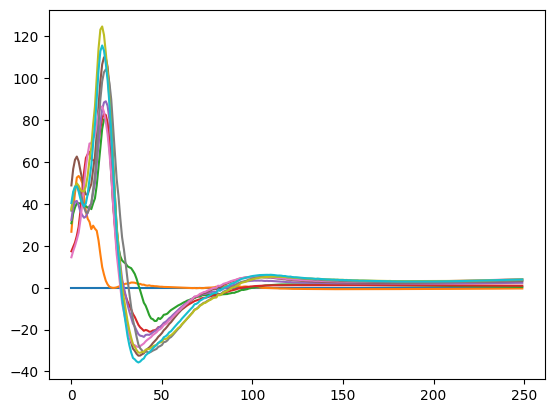

In [32]:
plt.plot(interiors[:5].T)
plt.show()

In [27]:
iters = 100
key = jax.random.PRNGKey(np.random.randint(0,1e5))
keys = jax.random.split(key, num=iters)

In [ ]:

def save_on_host(saver, data, transforms):
    saver.append(data)

data_rand = []
save_d = partial(save_on_host, data_rand)


In [ ]:


cfg = Config(problem='osc', sample=Sample(scheme_t='rand', bs_t=128))
_, _, loss_fn, arg_fn_rand, s_fn, params_init = build(cfg)


@jit
def do_loss(key):
    data = arg_fn_rand(key)
    
    loss, grad_loss = value_and_grad(loss_fn)(last_params, *data, key)
    grad_loss = jax.flatten_util.ravel_pytree(grad_loss)[0]
    return loss, grad_loss

losses, grads = [], []
for k in keys:
    l, g = do_loss(k)
    losses.append(l)
    grads.append(g)
losses_rand = np.asarray(losses)
grads = np.asarray(grads)

u, s, vt = jnp.linalg.svd(grads)
s_rand = s/s[0]
v_rand = np.var(losses_rand/ np.linalg.norm(losses_rand))

In [ ]:
from hflow.run import build
from hflow.config import Config, Sample

cfg = Config(problem='osc', sample=Sample(scheme_t='gauss', bs_t=128))
_, _, loss_fn, arg_fn_gauss, s_fn, params_init = build(cfg)

@jit
def do_loss(key):
    data = arg_fn_gauss(key)
    loss, grad_loss = value_and_grad(loss_fn)(last_params, *data, key)
    grad_loss = jax.flatten_util.ravel_pytree(grad_loss)[0]
    return loss, grad_loss

losses, grads = [], []
for k in keys:
    l, g = do_loss(k)
    losses.append(l)
    grads.append(g)
losses_gauss = np.asarray(losses)
grads = np.asarray(grads)

u, s, vt = jnp.linalg.svd(grads)
s_gauss = s/s[0]
v_gauss = np.var(losses_gauss/ np.linalg.norm(losses_gauss))

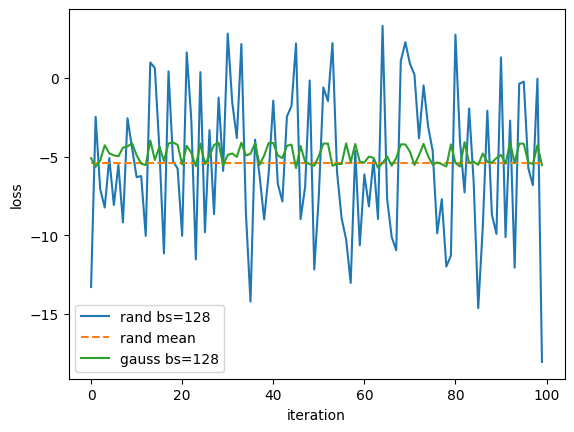

In [ ]:
o = np.ones_like(losses_rand)
plt.plot(losses_rand, label='rand bs=128')
plt.plot(o*np.mean(losses_rand), '--',  label='rand mean')
plt.plot(losses_gauss, label='gauss bs=128')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.legend()
plt.show()

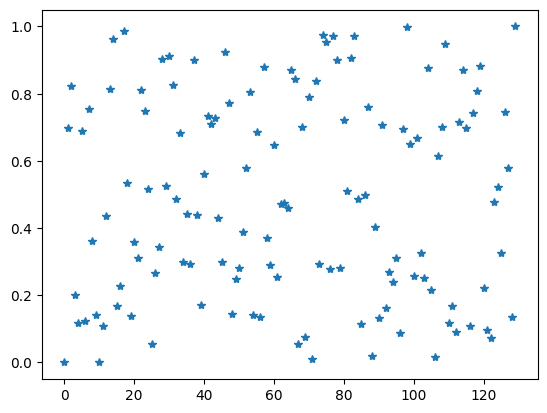

In [ ]:
sol, mu, t, q = arg_fn_rand(key)
plt.plot(t, '*')
plt.show()

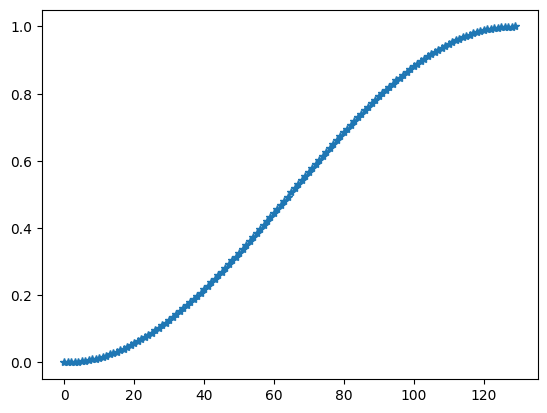

In [ ]:
sol, mu, t, q = arg_fn_gauss(key)
plt.plot(t, '*')
plt.show()

In [ ]:
np.sum(q)

Array(1., dtype=float32)

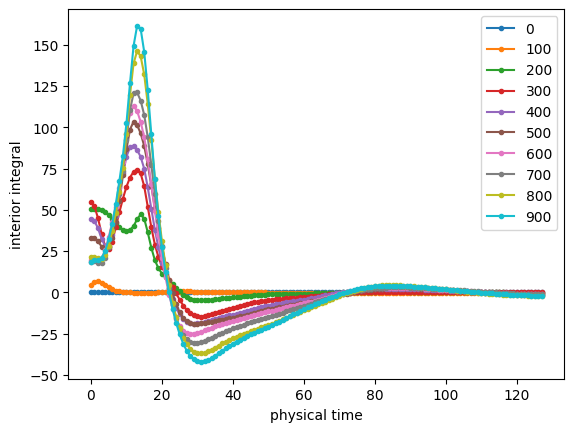

In [ ]:

loss_fn = Action_Match(s_fn, noise=0.0, sigma=0.0, return_interior=True)
data = arg_fn_equi(key)
loss, interior = loss_fn(last_params, *data, key)
plt.plot(interior, '.-')
plt.show()